## Crop Classification

#### Visualization of spation temporal input and expected outputs for crop type prediction models

# Crop type prediction Using 3d Unet

In [27]:
'''
conda deactivate
conda deactivate
cd stelar_3dunet/
source spt19/bin/activate
jupyter notebook
'''

'\nconda deactivate\nconda deactivate\ncd stelar_3dunet/\nsource spt19/bin/activate\njupyter notebook\n'

In [28]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)
from keras.models import load_model

from scipy.stats import mode


2.13.1
2.13.1


In [29]:
#Make sure the GPU is available. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()

2024-08-13 13:38:19.873115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 13:38:19.874669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 13:38:19.876070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [30]:
#Make sure the GPU is available. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2024-08-13 13:38:20.180672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 13:38:20.182072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 13:38:20.183395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [31]:
import segmentation_models_3D as sm
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

## Vista Crop Types

In [32]:
vista_crop_dict = { 0:'NA' , 1: 'ALFALFA', 2: 'BEET', 3: 'CLOVER', 4: 'FLAX', 5: 'FLOWERING_LEGUMES', 6: 'FLOWERS', 7: 'FOREST', 8: 'GRAIN_MAIZE', 9: 'GRASSLAND', 10: 'HOPS', 11: 'LEGUMES', 12: 'VISTA_NA', 13: 'PERMANENT_PLANTATIONS', 14: 'PLASTIC', 15: 'POTATO', 16: 'PUMPKIN', 17: 'RICE', 18: 'SILAGE_MAIZE', 19: 'SOY', 20: 'SPRING_BARLEY', 21: 'SPRING_OAT', 22: 'SPRING_OTHER_CEREALS', 23: 'SPRING_RAPESEED', 24: 'SPRING_RYE', 25: 'SPRING_SORGHUM', 26: 'SPRING_SPELT', 27: 'SPRING_TRITICALE', 28: 'SPRING_WHEAT', 29: 'SUGARBEET', 30: 'SUNFLOWER', 31: 'SWEET_POTATOES', 32: 'TEMPORARY_GRASSLAND', 33: 'WINTER_BARLEY', 34: 'WINTER_OAT', 35: 'WINTER_OTHER_CEREALS', 36: 'WINTER_RAPESEED', 37: 'WINTER_RYE', 38: 'WINTER_SORGHUM', 39: 'WINTER_SPELT', 40: 'WINTER_TRITICALE', 41: 'WINTER_WHEAT'}

# Loading of the test set

In [34]:
def get_labels_in_color(groud_truth_image):
    color_map = {0: [0, 0, 0], 1: [0, 255, 0], 2: [0, 0, 255], 3: [255, 255, 0], 4: [255, 165, 0], 5: [255, 0, 255], 6: [0, 255, 255], 7: [128, 0, 128], 8: [128, 128, 0], 9: [0, 128, 0], 10: [128, 0, 0], 11: [0, 0, 128], 12: [128, 128, 128], 13: [0, 128, 128], 14: [255, 0, 0], 15: [255, 255, 255], 16: [192, 192, 192], 17: [139, 0, 0], 18: [0, 100, 0], 19: [0, 0, 139], 20: [255, 215, 0], 21: [255, 140, 0], 22: [139, 0, 139], 23: [0, 206, 209], 24: [75, 0, 130], 25: [85, 107, 47], 26: [34, 139, 34], 27: [165, 42, 42], 28: [70, 130, 180], 29: [169, 169, 169], 30: [32, 178, 170], 31: [47, 79, 79], 32: [245, 245, 245], 33: [105, 105, 105], 34: [205, 92, 92], 35: [50, 205, 50], 36: [65, 105, 225], 37: [255, 223, 0], 38: [255, 99, 71], 39: [186, 85, 211], 40: [0, 191, 255], 41: [192, 192, 192]}

    groud_truth_color_image = np.zeros(groud_truth_image.shape + (3,), dtype=np.uint8)
    for i in range(groud_truth_image.shape[0]):
        for j in range(groud_truth_image.shape[1]):
            segment_id_gt = groud_truth_image[i, j]
            groud_truth_color_image[i, j] = color_map[segment_id_gt]
    return groud_truth_color_image


def replace_zeros_with_average(arr):
    for i in range(len(arr)):
        if arr[i] == 0:
            left = i - 1
            right = i + 1
            while left >= 0 and arr[left] == 0:
                left -= 1
            while right < len(arr) and arr[right] == 0:
                right += 1
            if left >= 0 and right < len(arr):
                arr[i] = (arr[left] + arr[right]) // 2
            elif left >= 0:
                arr[i] = arr[left]
            elif right < len(arr):
                arr[i] = arr[right]
    return arr

color_map = {0: [0, 0, 0], 1: [0, 255, 0], 2: [0, 0, 255], 3: [255, 255, 0], 4: [255, 165, 0], 5: [255, 0, 255], 6: [0, 255, 255], 7: [128, 0, 128], 8: [128, 128, 0], 9: [0, 128, 0], 10: [128, 0, 0], 11: [0, 0, 128], 12: [128, 128, 128], 13: [0, 128, 128], 14: [255, 0, 0], 15: [255, 255, 255], 16: [192, 192, 192], 17: [139, 0, 0], 18: [0, 100, 0], 19: [0, 0, 139], 20: [255, 215, 0], 21: [255, 140, 0], 22: [139, 0, 139], 23: [0, 206, 209], 24: [75, 0, 130], 25: [85, 107, 47], 26: [34, 139, 34], 27: [165, 42, 42], 28: [70, 130, 180], 29: [169, 169, 169], 30: [32, 178, 170], 31: [47, 79, 79], 32: [245, 245, 245], 33: [105, 105, 105], 34: [205, 92, 92], 35: [50, 205, 50], 36: [65, 105, 225], 37: [255, 223, 0], 38: [255, 99, 71], 39: [186, 85, 211], 40: [0, 191, 255], 41: [192, 192, 192]}


In [35]:
import gc

BACKBONE = 'vgg16'  #Try vgg16, efficientnetb7, inceptionv3, resnet50

#BACKBONE = 'resnet50'  #Try vgg16, efficientnetb7, inceptionv3, resnet50

preprocess_input = sm.get_preprocessing(BACKBONE)

In [36]:

class_weights =  True

if class_weights:
    chosen_crop_types_list_list = [[1, 2, 3], [4, 5, 7], [8,  9, 10], [11, 12, 13], [14, 15, 16], [18, 19, 20], [21, 23, 27], [28, 30, 32], [33, 34, 35], [36, 37, 40], [37, 40, 41]]
    #chosen_crop_types_list_list = [[4, 5, 7]]
else:
    chosen_crop_types_list_list = [[1, 2, 3], [4, 5, 7], [8,  9, 10], [11, 12, 13], [14, 15, 16], [18, 19, 20], [21, 23, 27], [28, 30, 32], [33, 34, 35], [36, 37, 40], [37, 40, 41]]
chosen_crop_types_list_list

[[1, 2, 3],
 [4, 5, 7],
 [8, 9, 10],
 [11, 12, 13],
 [14, 15, 16],
 [18, 19, 20],
 [21, 23, 27],
 [28, 30, 32],
 [33, 34, 35],
 [36, 37, 40],
 [37, 40, 41]]

In [58]:
chosen_crop_types_list_list[9],len(chosen_crop_types_list_list)

([36, 37, 40], 11)

1/1 [==============================] - 0s 358ms/step


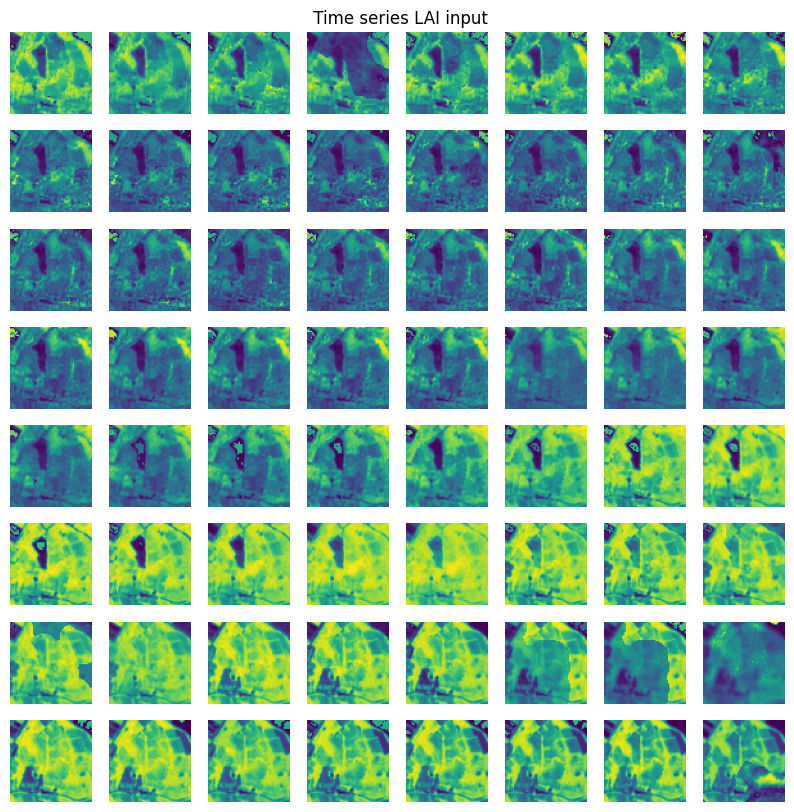

uniq_crop_vals [ 0.  3.  8.  9. 11. 16. 30. 32. 33. 41.]


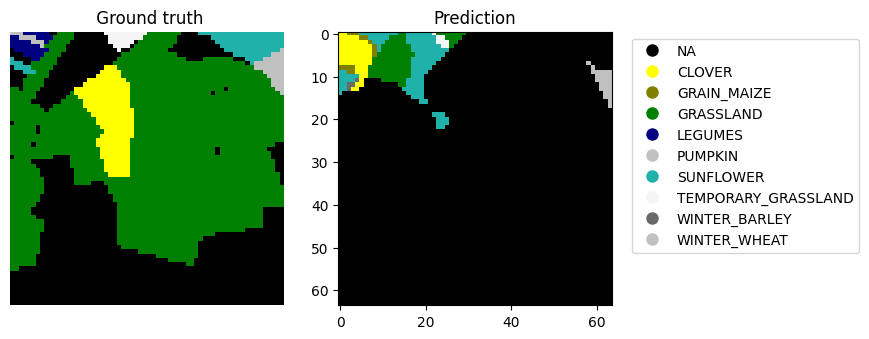

In [94]:
cloud_interpolation = True
test_img_number = 159
chosen_subset_for_test_set = 4

stacked_test_preds = []
num_epochs = 450
X_test = io.imread('/home/luser/stelar_3dunet/storage/test_sets_of_subsets_all/X_test_contains'+vista_crop_dict[chosen_crop_types_list_list[chosen_subset_for_test_set][0]]+'_'+vista_crop_dict[chosen_crop_types_list_list[chosen_subset_for_test_set][1]]+'_'+vista_crop_dict[chosen_crop_types_list_list[chosen_subset_for_test_set][2]]+'_.tif')
y_test_1 = io.imread('/home/luser/stelar_3dunet/storage/test_sets_of_subsets_all/y_test_all_contains'+vista_crop_dict[chosen_crop_types_list_list[chosen_subset_for_test_set][0]]+'_'+vista_crop_dict[chosen_crop_types_list_list[chosen_subset_for_test_set][1]]+'_'+vista_crop_dict[chosen_crop_types_list_list[chosen_subset_for_test_set][2]]+'_.tif')

ensambled_ground_truth = np.zeros((64, 64))
ensambled_result_image = np.zeros((64, 64))
ensambled_result_image_gen = np.zeros((64, 64, 64))

test_img = X_test[test_img_number-1]

if cloud_interpolation:
    for i in range(64):
        for j in range(64):
            for c in range(3):
                exp_time_strip = test_img[:, i, j, c]
                exp_time_strip_av = replace_zeros_with_average(exp_time_strip)
                test_img[:, i, j, c] = exp_time_strip_av
test_img = test_img.astype(np.uint8)
test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input, backend='tf')

ground_truth_1 = y_test_1[test_img_number-1]
ground_truth_flattened = ground_truth_1[0,:,:]

for chosen_crop_types_list in chosen_crop_types_list_list:

    gc.collect()
    if class_weights:
        my_model_1 = load_model('/home/luser/stelar_3dunet/storage/saved_model_bias_miti_class_weights_corrected_more_data/3D_unet_res_labels_'+vista_crop_dict[chosen_crop_types_list[0]]+'_'+vista_crop_dict[chosen_crop_types_list[1]]+'_'+vista_crop_dict[chosen_crop_types_list[2]]+'_num_epocs_'+str(num_epochs)+'.h5', compile=False)
    else:
        my_model_1 = load_model('/home/luser/stelar_3dunet/storage/saved_model/3D_unet_res_labels_'+vista_crop_dict[chosen_crop_types_list[0]]+'_'+vista_crop_dict[chosen_crop_types_list[1]]+'_'+vista_crop_dict[chosen_crop_types_list[2]]+'_num_epocs_'+str(num_epochs)+'.h5', compile=False)

    test_pred1 = my_model_1.predict(test_img_input1)
    del my_model_1
    gc.collect()
    test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]

    for i in range(3):
        test_prediction1[test_prediction1==i+1]= chosen_crop_types_list[i]
    for i in range(3):
        ensambled_result_image_gen[test_prediction1==chosen_crop_types_list[i]]=chosen_crop_types_list[i]
    stacked_test_preds.append(ensambled_result_image_gen.copy())
    ensambled_result_image_gen = np.zeros((64, 64, 64))

stacked_test_preds = np.concatenate((stacked_test_preds), axis=0)
ensambled_result_image_gen = np.median(stacked_test_preds, axis=0).astype(np.uint8)

test_mode = np.zeros((64, 64))
for i in range(64):
    for j in range(64):
        see = stacked_test_preds[:, i, j]
        sum_see = np.sum(see)
        if sum_see == 0:
            test_mode[i, j] = 0
        else:
            local_mode = mode(see[see>0])[0]
            test_mode[i, j]= local_mode
            
test_mode_c = get_labels_in_color(test_mode)
ensambled_ground_truth_c = get_labels_in_color(ground_truth_flattened)

plt.figure(figsize=(10,10))
plt.title(' Time series LAI input')
for i in range(64):
    plt.axis('off')
    plt.subplot(8, 8, i+1)
    plt.imshow(test_img[i,:,:, 1])
    plt.axis('off')
if cloud_interpolation:
    plt.savefig('/home/luser/stelar_3dunet/showcase/after_class_weights_with_interpolation/LAI_subset_'+str(chosen_subset_for_test_set)+'_sample_'+str(test_img_number)+'_.png', bbox_inches='tight')
else:
    plt.savefig('/home/luser/stelar_3dunet/showcase/after_class_weights_without_interpolation/LAI_subset_'+str(chosen_subset_for_test_set)+'_sample_'+str(test_img_number)+'_.png', bbox_inches='tight')
plt.show()
plt.close()


plt.figure(figsize=(12, 8))
plt.subplot(232)
plt.title(' Ground truth')
plt.imshow(ensambled_ground_truth_c)
plt.axis('off')

legend_elements = []
concatenated_ensambles = np.concatenate((ground_truth_flattened, test_mode))
uniq_crop_vals = np.unique(concatenated_ensambles)
print("uniq_crop_vals", uniq_crop_vals)
for k in uniq_crop_vals:
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=[value / 255 for value in color_map[k]] , markersize=10, label=vista_crop_dict[k]))
plt.subplot(233)
plt.title('Prediction')
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.imshow(test_mode_c)

if cloud_interpolation:
    plt.savefig('/home/luser/stelar_3dunet/showcase/after_class_weights_with_interpolation/ground_truth_pred_subset_'+str(chosen_subset_for_test_set)+'_sample_'+str(test_img_number)+'_.png', bbox_inches='tight')
else:
    plt.savefig('/home/luser/stelar_3dunet/showcase/after_class_weights_without_interpolation/ground_truth_pred_subset_'+str(chosen_subset_for_test_set)+'_sample_'+str(test_img_number)+'_.png', bbox_inches='tight')
plt.show()
plt.close()
